# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.preprocessing import scale
from tensorflow.contrib.layers import flatten

---
## Step 0: Load The Data

In [2]:
# Load pickled data

path_to_data = '../data/'
training_file = path_to_data+'train.p'
validation_file=path_to_data+'valid.p'
testing_file = path_to_data+'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset
n_classes = np.unique(np.concatenate([y_train, y_valid, y_test])).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


The dataset is made of 32x32 RGB images. It is already splitted in three different parts:
- Training datasets: 34799 images
- Validation dataset: 4410 images
- Testing dataset: 12630 images

There are **43** overall different labels in the datasets

### Exploratory visualization and descriptive analysis

In [4]:
sign_names = pd.read_csv("signnames.csv")

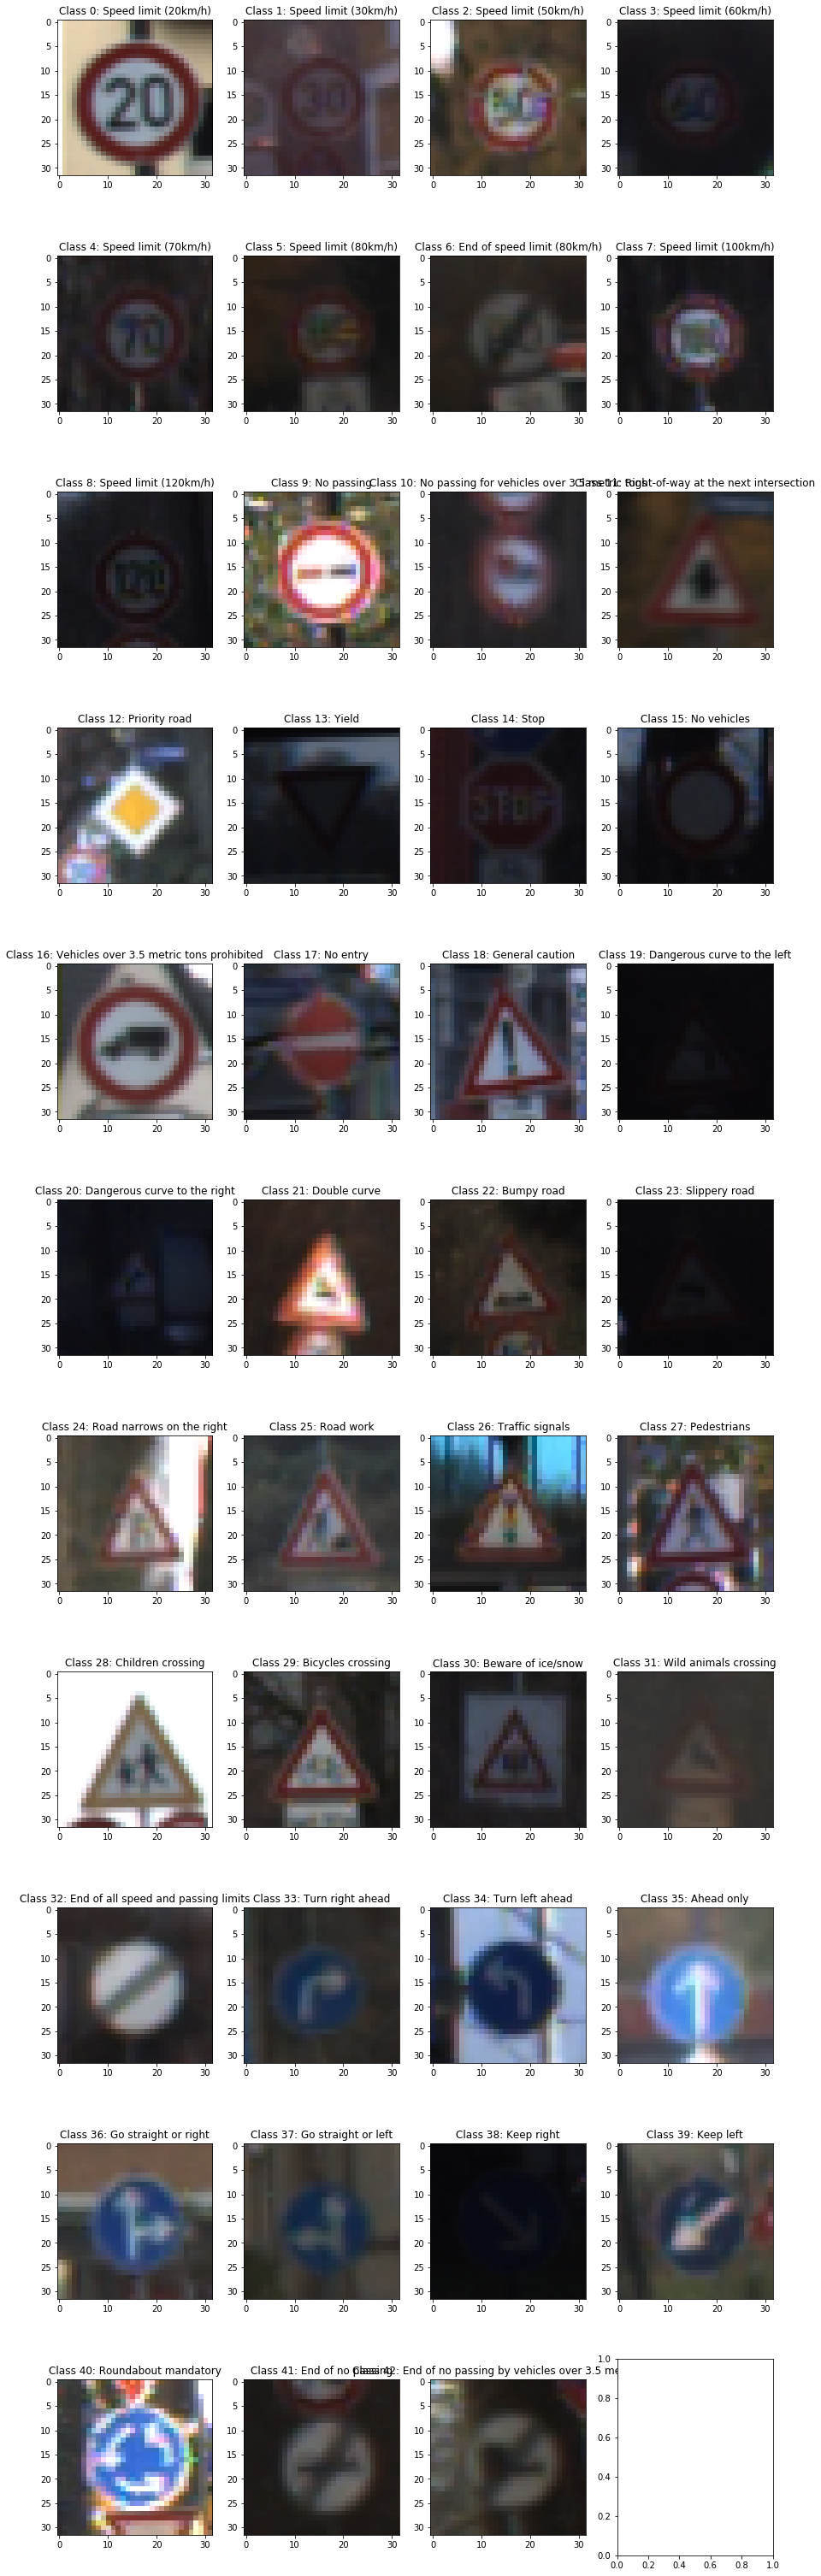

In [5]:
f, axs = plt.subplots(11,4,figsize=(15,55))
axs = axs.reshape(-1)

for c in np.arange(n_classes):
    axs[c].imshow(X_train[y_train == c][0])
    axs[c].set_title("Class {}: {}".format(c, sign_names[(sign_names['ClassId'] == c)]['SignName'].iloc[0]))
    
plt.show()

The dataset is evidently unbalanced, as it can be seen from the plot below. It is important to address this to avoid having a biased network towards certain classes.

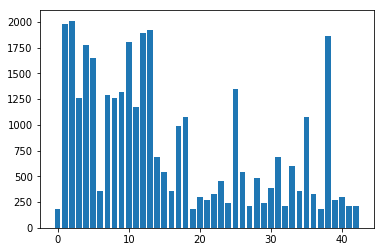

In [6]:
class_freq = np.bincount(y_train)
plt.bar(np.arange(n_classes), class_freq)
plt.show()

In [7]:
perc_array = [25, 33, 50, 67, 75, 100]
quant = np.int32(np.percentile(class_freq, perc_array))
min_samples = np.min(class_freq)
max_samples = np.max(class_freq)
for i, q in enumerate(perc_array):
    print("{}% : {} samples".format(q, quant[i]))
print("Min number of samples: " + str(min_samples))
print("Max number of samples: " + str(max_samples))

25% : 285 samples
33% : 330 samples
50% : 540 samples
67% : 1092 samples
75% : 1275 samples
100% : 2010 samples
Min number of samples: 180
Max number of samples: 2010


----

## Step 2: Design and Test a Model Architecture

The following preprocessing steps have been applied, since they consistently improved the validation accuracy:
-  Data Augmentation through rotation and resizing to obtain a balanced datasets
-  A further augmentation step by adding noisy version of some of the images.
- Convert the image from RGB to YUV.
- Select only the Y channel is selected
Normalization has been tried out as well, but since it worsened the performance, it was decided not to add it

### Dataset augmentation to balance training dataset

It would be desirable to obtain a training dataset where all the classes have an equal number of images. The class with the highest number of samples has 2010 images, so by augmenting the dataset it is possible to retrieve the missing images for having 2010 samples for each classes.
For each classes, as many images as needed to reach 2010 are bootstrap-sampled from the original datasets, then they are jittered in two different ways. The first half is rotated and the second halfed is resized, i.e. zoomed in or out but mantaining the same resolution (this is achieved with a perspective transform). The angle of rotation and the resizing scale are randomly selected for each image from a uniform distribution between two bounding values. The values selected here are [-15, 15] degrees and [0.9,1.1] for the resizing scale, as used in the paper *Taffic Sign Recognition with Multi-Scale Convolutional Networks* by Sermanet and LeCun

In [8]:
def random_rotation(data, max_angle=15):
    rand_angle = np.random.random((len(data),)) * max_angle * 2 - max_angle
    for idx, img in enumerate(data):
        R = cv2.getRotationMatrix2D((16,16), len(data), 1)
        data[idx] = cv2.warpAffine(img , R, (32,32))
    return data

In [9]:
def random_resize(data, resize_max=0.1):
    src = np.float32([[0, 32], [0,0], [32, 0], [32, 32]])
    rand_resize = (np.random.random((len(data),)) * resize_max * 2 - resize_max) * 32
    for idx, img in enumerate(data):
        dst = np.float32([[0, rand_resize], [0,0], [rand_resize, 0], [rand_resize, rand_resize]])
        M = cv2.getPerspectiveTransform(src, dst)
        data[idx] = cv2.warpPerspective(img, M, (32, 32), flags=cv2.INTER_LINEAR)
    return data

In [10]:
def augm_image(data, min_samples, max_angle=15, resize_max=0.1):

    # Bootstrap sample image for augmentation
    datasize = min_samples - len(data)
    dataidxs = np.arange(len(data))
    sampleidxs = np.random.choice(dataidxs, size=(datasize,), replace=True)
    sampled_data = data[sampleidxs]
    
    # Jitter selected images
    data_rot = sampled_data[:len(sampled_data)//2]
    data_resize = sampled_data[len(sampled_data)//2:]
   
    
    return sampled_data

In [11]:
# Augment dataset to get enough samples for each class
for c in range(43):
    if class_freq[c] < max_samples:
        augmented_imgs = augm_image(X_train[(y_train == c)], max_samples)
        X_train = np.concatenate([X_train, augmented_imgs])
        y_train = np.concatenate([y_train, np.ones((augmented_imgs.shape[0],),dtype=np.uint8) * c])
    else:
        pass

Augmented training dataset size: 86430 samples


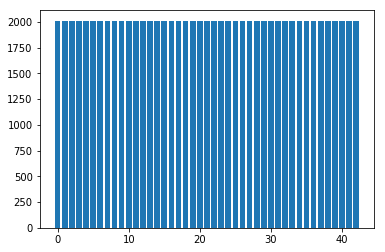

In [12]:
# Check dataset size and class_freq now
n_train_aug = len(y_train)
print("Augmented training dataset size: {} samples".format(n_train_aug))

class_freq_aug = np.bincount(y_train)
plt.bar(np.arange(n_classes), class_freq_aug)
plt.show()

The datasets now contains 86430 samples and it is balanced

### Data augmentation with noise

To make the network more robust, random gaussian noise is added to all the channels. The scale for the normal distribution of the noise becomes thus an hyperparameter of the system. Setting it to **5** returned the best performances among the values considered. The images to be samples are once again bootstrap-sampled from the original datasets.

In [13]:
n_noise = n_train
noise_scale = 5

# Bootstrap sample images and add noise
noise_idxs = np.random.choice(np.arange(n_train_aug),size=(n_noise,),replace=True)
noisy_data = X_train[noise_idxs] + np.uint8(np.random.normal(loc=0.,scale=noise_scale, size=(n_noise,32,32,3)))
X_train = np.concatenate([X_train, noisy_data])
y_train = np.concatenate([y_train, y_train[noise_idxs]])                                                                       

Final training dataset size: 121229 samples


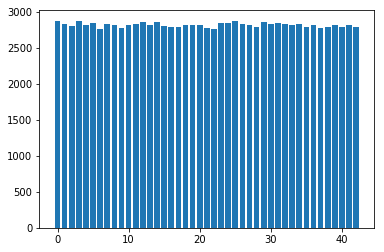

In [14]:
# Check dataset size and class_freq now
n_train_fin = len(y_train)
print("Final training dataset size: {} samples".format(n_train_fin))

class_freq_fin = np.bincount(y_train)
plt.bar(np.arange(n_classes), class_freq_fin)
plt.show()

### From RGB to YUV dataset

The LeNet-5 architecture has been firstly implemented for non-color images, so it performed better on only color channel. This single channel is the Y channel of the YUV color map.

In [15]:
rgb2yuv = lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [16]:
X_train = np.array(list(map(rgb2yuv, X_train)))
X_valid = np.array(list(map(rgb2yuv, X_valid)))
X_test = np.array(list(map(rgb2yuv, X_test)))

In [17]:
# Only Y channel
X_train = X_train[:,:,:,0].reshape(len(X_train),32,32,1)
X_valid = X_valid[:,:,:,0].reshape(len(X_valid),32,32,1)
X_test = X_test[:,:,:,0].reshape(len(X_test),32,32,1)

### Model Architecture

The architecture is the classic LeNet-5 architecture, with 2 convolutional + max_pooling layers, and 2 fully connected layers for classification. Only two modification have been added:
- The depth of the convolutional layers has been doubled to 12 and 32
- Dropout with 25% rate has been added after the second convolutional layers

In [18]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Dropout
    conv2 = tf.nn.dropout(conv2,keep_prob=0.75)

    # Pooling. Input = 10x10x32. Output = 5x5x32
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

After several attempts, the following hyperparameters have been set:
- Number of epochs: 
- Batch size: 128
- Learning rate: 0.0009

The validation accuracy reached is **94.4%**, whereas the test accuracy is **92.0%**

### Train the model

In [19]:
EPOCHS = 25
BATCH_SIZE = 128

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [21]:
rate = 9e-4

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.817

EPOCH 2 ...
Validation Accuracy = 0.893

EPOCH 3 ...
Validation Accuracy = 0.906

EPOCH 4 ...
Validation Accuracy = 0.915

EPOCH 5 ...
Validation Accuracy = 0.922

EPOCH 6 ...
Validation Accuracy = 0.919

EPOCH 7 ...
Validation Accuracy = 0.925

EPOCH 8 ...
Validation Accuracy = 0.919

EPOCH 9 ...
Validation Accuracy = 0.920

EPOCH 10 ...
Validation Accuracy = 0.922

EPOCH 11 ...
Validation Accuracy = 0.915

EPOCH 12 ...
Validation Accuracy = 0.912

EPOCH 13 ...
Validation Accuracy = 0.940

EPOCH 14 ...
Validation Accuracy = 0.934

EPOCH 15 ...
Validation Accuracy = 0.926

EPOCH 16 ...
Validation Accuracy = 0.933

EPOCH 17 ...
Validation Accuracy = 0.944

EPOCH 18 ...
Validation Accuracy = 0.925

EPOCH 19 ...
Validation Accuracy = 0.952

EPOCH 20 ...
Validation Accuracy = 0.945

EPOCH 21 ...
Validation Accuracy = 0.944

EPOCH 22 ...
Validation Accuracy = 0.938

EPOCH 23 ...
Validation Accuracy = 0.951

EPOCH 24 ...
Validation Accura

### Test model

In [33]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.920


---

## Step 3: Test a Model on New Images

### Acquiring new images

5 new images of German Traffic Sign have been found on the web. Since they appear in greater picture they have been cropped, resized to 32x32 and converted to .png format prior to upload. Despite being apparently easy for our model, they are a bit different from the images in the test set, especially in size. It is expected that the model will not peform well because it was trained on a dataset with particular and recurrent characteristics, not present in these 5 new images.

In [116]:
### Load the images and plot them here
images = glob.glob("./my_dataset/*")
X_web = []
for img in images:
    X_web.append(mpimg.imread(img).reshape(1,32,32,3))
X_web = np.concatenate(X_web)

In [117]:
print("There are {} new images".format(len(X_web)))
print("Dataset shape: " + str(X_web.shape))

There are 5 new images
Dataset shape: (5, 32, 32, 3)


In [118]:
images

['./my_dataset/12.png',
 './my_dataset/38.png',
 './my_dataset/4.png',
 './my_dataset/15.png',
 './my_dataset/13.png']

In [119]:
y_web = np.array([12,38,4,15,13], dtype=np.uint8)

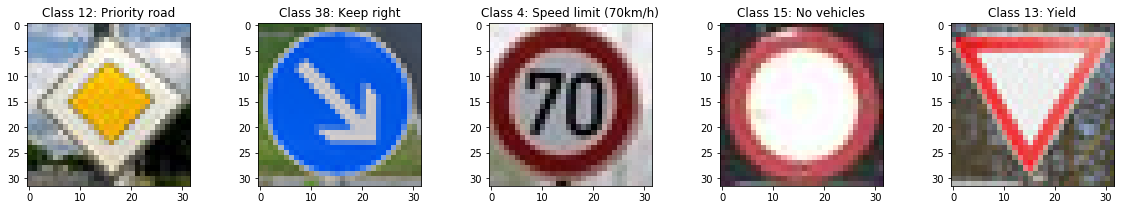

In [120]:
f, axs = plt.subplots(1,5,figsize=(20,3))

for i, c in enumerate(y_web):
    axs[i].imshow(X_web[i])
    axs[i].set_title("Class {}: {}".format(c, sign_names[(sign_names['ClassId'] == c)]['SignName'].iloc[0]))

plt.show()

### Predict the Sign Type for Each Image

In [121]:
# Preprocessing
X_web_p = np.array(list(map(rgb2yuv, X_web)))
X_web_p = X_web_p[:,:,:,0].reshape(len(X_web_p),32,32,1)

In [122]:
softmax_prob = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_score = sess.run(softmax_prob, feed_dict={x: X_web_p, y: y_web})

INFO:tensorflow:Restoring parameters from ./lenet


In [123]:
prob_score = softmax_score.max(axis=1)
class_pred = softmax_score.argmax(axis=1)

In [124]:
for i, c in enumerate(y_web):
    pred = sign_names[(sign_names['ClassId'] == class_pred[i])]['SignName'].iloc[0]
    prob = prob_score[i] * 100
    real = sign_names[(sign_names['ClassId'] == c)]['SignName'].iloc[0]
    print("Image {}: predicted {} at {:.2f}%, actual class: {}".format(i+1,pred,prob,real))

Image 1: predicted Turn right ahead at 18.17%, actual class: Priority road
Image 2: predicted Speed limit (60km/h) at 33.78%, actual class: Keep right
Image 3: predicted Speed limit (60km/h) at 37.84%, actual class: Speed limit (70km/h)
Image 4: predicted Speed limit (60km/h) at 17.36%, actual class: No vehicles
Image 5: predicted Speed limit (60km/h) at 25.40%, actual class: Yield


### Analyze Performance

In [133]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    web_accuracy = sess.run(accuracy_operation, feed_dict={x: X_web_p, y: y_web})
    print("Accuracy on web dataset = {:.3f}".format(web_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Accuracy on web dataset = 0.000


The model fails at correctly classifying any of the image, actually struggling to report any label with certainty (all the top-1 probabilities are well far from 100%). This confirms the remarks previously made.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [126]:
softmax_top5_class = np.flip(softmax_score.argsort(axis=1)[:,-5:], axis=1)
softmax_top5_prob = np.flip(np.sort(softmax_score, axis=1)[:,-5:], axis=1)

for i, c in enumerate(y_web):
    print("Image {}: {}".format(i+1, sign_names[(sign_names['ClassId'] == c)]['SignName'].iloc[0]))
    for j in range(5):
        pred = sign_names[(sign_names['ClassId'] == softmax_top5_class[i,j])]['SignName'].iloc[0]
        print("{}. {:.2f}% {}".format(j+1, softmax_top5_prob[i,j] * 100, pred))
    print()

Image 1: Priority road
1. 18.17% Turn right ahead
2. 18.15% Speed limit (60km/h)
3. 9.49% Speed limit (80km/h)
4. 6.62% Yield
5. 6.25% No entry

Image 2: Keep right
1. 33.78% Speed limit (60km/h)
2. 12.51% Speed limit (80km/h)
3. 7.43% General caution
4. 7.22% Turn right ahead
5. 5.53% Yield

Image 3: Speed limit (70km/h)
1. 37.84% Speed limit (60km/h)
2. 16.78% Speed limit (80km/h)
3. 8.92% Turn right ahead
4. 6.81% Speed limit (70km/h)
5. 5.13% General caution

Image 4: No vehicles
1. 17.36% Speed limit (60km/h)
2. 15.41% Turn right ahead
3. 13.45% Speed limit (80km/h)
4. 6.82% Yield
5. 5.62% Priority road

Image 5: Yield
1. 25.40% Speed limit (60km/h)
2. 13.89% Speed limit (80km/h)
3. 13.82% Turn right ahead
4. 11.44% Yield
5. 6.44% Speed limit (70km/h)



Even considering the top-5 probabilities, the model performs very poorly in classifying the images. Only in 2 cases the correct label appear in the top5 predictions, with a very low score. Such low probabilites signify that the model is not practically misclassifying but it is very uncertain and unable to give a prediction whatsoever. Several images such as the ones found on the web need to be inserted in the training dataset in order to classify this other kind of images.